In [1]:
import pandas as pd #To work with dataset
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
import torch.nn.functional as nf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import cv2
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
data = pd.read_csv('UCI_Credit_Card.csv')
models_type = ["MLP"]
fig_address = ['./Output/MLP']
# glimpse at the data
data.head()
data.info()

# 2.数据清洗
# relabel EDUCATION information
fil = (data.EDUCATION == 5) | (data.EDUCATION == 6) | (data.EDUCATION == 0)
data.loc[fil, 'EDUCATION'] = 4

# relabel MARRIAGE information
data.loc[data.MARRIAGE == 0, 'MARRIAGE'] = 3

# rename column
data = data.rename(columns={'default.payment.next.month':'def_pay','PAY_0':'PAY_1'})

data = data.iloc[:, 1:]
# data = np.array(data, type(float))
data = data.to_numpy(dtype=np.float32)
# print(data.shape)
# 删除数据的第一列并对其进行标准化操作
for ii in range(data.shape[1]-1):
    meanVal=np.mean(data[:,ii])
    stdVal=np.std(data[:,ii])
    data[:,ii]=(data[:,ii]-meanVal)/stdVal

train, test = train_test_split(data, test_size = 0.2, random_state=27893,stratify=data[:,-1])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [3]:
class UCL_Credit_Card_dataset(torch.utils.data.Dataset):
  def __init__(self, setname):
    self.setname=setname
    if setname=='train':
      X=train
    if setname=='val':
      X=test
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    data = self.X[index,0:-1]
    data = torch.tensor(data, dtype=torch.float32)
    label = self.X[index,-1]
    label = torch.tensor(label, dtype=torch.int64)
    data_pair = {'X': data, 'y': label}
    return data_pair

In [4]:
#network setting
#device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#network structure
#net = nn.Sequential(nn.Linear(25,16), nn.ReLU(),nn.Dropout(0.45),nn.Linear(16, 2))

# net = nn.Sequential(nn.Linear(23, 22),nn.ReLU(),nn.Dropout(0.4),nn.Linear(22, 16),nn.ReLU(),nn.Dropout(0.2),nn.Linear(16, 2))
class Net(nn.Module):
        # fc 全连接层
        def __init__(self):
            super().__init__()
            #Conv2d[ channels, output, height_2, width_2 ]
            self.conv1 = torch.nn.Sequential(
            torch.nn.Conv1d(1, 10, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=1),
        )
            self.conv2 = torch.nn.Sequential(
            torch.nn.Conv1d(10, 20, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(kernel_size=1),
        )
            self.fc1 = nn.Linear(460,20)
            self.fc2 = nn.Linear(20,2)
            
        def forward(self, x):
            # print(x.shape)
            # print(x.shape)
            # print(x.shape)
            batch_size = x.size(0)
            x = x.view(batch_size,1,-1)
            # print(x.shape)
            # print(x.shape)
            x = self.conv1(x)
            x = self.conv2(x)
            # print(x.shape)
            # print(x.shape)
            # print(x.shape)
            x = x.view(batch_size,-1)
            # print(x.shape)
            x = nf.relu(self.fc1(x))
            x = nf.relu(self.fc2(x))
            return x

net = Net().to(device)

#initialization
# def init_weights(m):
#     if type(m) == nn.Linear:
#         nn.init.normal_(m.weight, std=0.01)
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0.01)
net.apply(init_weights)
lr, st_epoch,num_epoch = 0.01,0,10
Loss = nn.CrossEntropyLoss()
optim = torch.optim.SGD(net.parameters(), lr=lr)
#optim = torch.optim.AdamW(net.parameters(),lr=lr,betas=(0.9,0.999),eps=1e-8,weight_decay=0.01,amsgrad=False)#0.001
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer =optim,T_max=num_epoch)

#load train and val data
batch_size = 16
dataset_train = UCL_Credit_Card_dataset(setname='train')
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
num_data_train = len(dataset_train)
num_batch_train = np.ceil(num_data_train / batch_size)

dataset_val = UCL_Credit_Card_dataset(setname='val')
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
num_data_val = len(dataset_val)
num_batch_val = np.ceil(num_data_val / batch_size)

#get accuracy
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())


In [5]:
#training process
#log to record loss and acc
log=np.zeros([num_epoch,3])#train_loss,val_loss,val_accuracy
for epoch in range(st_epoch+1, num_epoch + 1):
    #training
    net.train()
    train_loss = []
    train_acc=[]
    for batch, data in enumerate(loader_train, 1):
        # forward pass
        image = data['X'].to(device)
        label = data['y'].to(device).reshape(-1)
        # print(image.shape, label.shape)
        output = net(image)
        # backward pass
        optim.zero_grad()
        loss = Loss(output, label)
        loss.backward()
        optim.step()
        train_loss += [loss.item()]
        print("TRAIN : EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %  (epoch, num_epoch, batch, num_batch_train, np.mean(train_loss)))
    log[epoch-1,0]=np.mean(train_loss)
    #scheduler.step()
    #validation
    net.eval()
    val_loss = []
    val_acc=[]
    for batch, data in enumerate(loader_val, 1):
        with torch.no_grad():
            # forward pass
            image = data['X'].to(device)
            label = data['y'].to(device).reshape(-1)
            output = net(image)
            loss = Loss(output, label)
            val_loss.append(loss.item())
            val_acc+=[accuracy(output,label)]
            print("VALID : EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" % (epoch, num_epoch, batch, num_batch_val, np.mean(val_loss)))
    log[epoch-1,1]=np.mean(val_loss)
    log[epoch-1,2]=np.sum(val_acc)/(num_batch_val*batch_size)

TRAIN : EPOCH 0001 / 0010 | BATCH 0001 / 1500 | LOSS 0.7114
TRAIN : EPOCH 0001 / 0010 | BATCH 0002 / 1500 | LOSS 0.7146
TRAIN : EPOCH 0001 / 0010 | BATCH 0003 / 1500 | LOSS 0.7131
TRAIN : EPOCH 0001 / 0010 | BATCH 0004 / 1500 | LOSS 0.7094
TRAIN : EPOCH 0001 / 0010 | BATCH 0005 / 1500 | LOSS 0.7075
TRAIN : EPOCH 0001 / 0010 | BATCH 0006 / 1500 | LOSS 0.7033
TRAIN : EPOCH 0001 / 0010 | BATCH 0007 / 1500 | LOSS 0.7006
TRAIN : EPOCH 0001 / 0010 | BATCH 0008 / 1500 | LOSS 0.6991
TRAIN : EPOCH 0001 / 0010 | BATCH 0009 / 1500 | LOSS 0.6961
TRAIN : EPOCH 0001 / 0010 | BATCH 0010 / 1500 | LOSS 0.6940
TRAIN : EPOCH 0001 / 0010 | BATCH 0011 / 1500 | LOSS 0.6928
TRAIN : EPOCH 0001 / 0010 | BATCH 0012 / 1500 | LOSS 0.6905
TRAIN : EPOCH 0001 / 0010 | BATCH 0013 / 1500 | LOSS 0.6898
TRAIN : EPOCH 0001 / 0010 | BATCH 0014 / 1500 | LOSS 0.6882
TRAIN : EPOCH 0001 / 0010 | BATCH 0015 / 1500 | LOSS 0.6870
TRAIN : EPOCH 0001 / 0010 | BATCH 0016 / 1500 | LOSS 0.6849
TRAIN : EPOCH 0001 / 0010 | BATCH 0017 /

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10176\2872382937.py:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.int64)


TRAIN : EPOCH 0001 / 0010 | BATCH 0033 / 1500 | LOSS 0.6591
TRAIN : EPOCH 0001 / 0010 | BATCH 0034 / 1500 | LOSS 0.6587
TRAIN : EPOCH 0001 / 0010 | BATCH 0035 / 1500 | LOSS 0.6579
TRAIN : EPOCH 0001 / 0010 | BATCH 0036 / 1500 | LOSS 0.6569
TRAIN : EPOCH 0001 / 0010 | BATCH 0037 / 1500 | LOSS 0.6564
TRAIN : EPOCH 0001 / 0010 | BATCH 0038 / 1500 | LOSS 0.6557
TRAIN : EPOCH 0001 / 0010 | BATCH 0039 / 1500 | LOSS 0.6560
TRAIN : EPOCH 0001 / 0010 | BATCH 0040 / 1500 | LOSS 0.6544
TRAIN : EPOCH 0001 / 0010 | BATCH 0041 / 1500 | LOSS 0.6525
TRAIN : EPOCH 0001 / 0010 | BATCH 0042 / 1500 | LOSS 0.6521
TRAIN : EPOCH 0001 / 0010 | BATCH 0043 / 1500 | LOSS 0.6508
TRAIN : EPOCH 0001 / 0010 | BATCH 0044 / 1500 | LOSS 0.6521
TRAIN : EPOCH 0001 / 0010 | BATCH 0045 / 1500 | LOSS 0.6509
TRAIN : EPOCH 0001 / 0010 | BATCH 0046 / 1500 | LOSS 0.6490
TRAIN : EPOCH 0001 / 0010 | BATCH 0047 / 1500 | LOSS 0.6481
TRAIN : EPOCH 0001 / 0010 | BATCH 0048 / 1500 | LOSS 0.6478
TRAIN : EPOCH 0001 / 0010 | BATCH 0049 /

[[0.48704303 0.45689413 0.81016667]
 [0.44468984 0.45765884 0.81083333]
 [0.43933469 0.44430262 0.81566667]
 [0.43716186 0.43984788 0.81633333]
 [0.4353953  0.44077303 0.81616667]
 [0.4337935  0.44195925 0.81766667]
 [0.43310692 0.43721227 0.816     ]
 [0.4316578  0.44290335 0.81833333]
 [0.43077758 0.43502786 0.81933333]
 [0.42992387 0.43684132 0.81933333]]


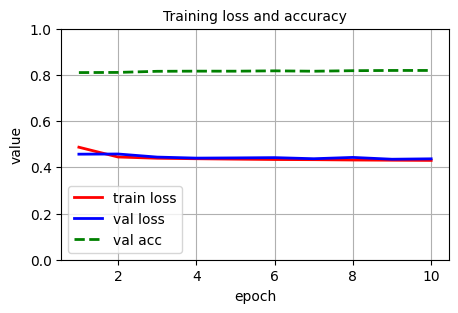

In [6]:
#plot the curve of loss and acc
print(log)
x=np.arange(num_epoch)
x=x+1
plt.figure(figsize=(5,3))
plt.plot(x,log[:,0],linestyle='-',color='r',label='train loss',linewidth=2)
plt.plot(x,log[:,1],linestyle='-',color='b',label='val loss',linewidth=2)
plt.plot(x,log[:,2],linestyle='--',color='g',label='val acc',linewidth=2)
plt.title('Training loss and accuracy',fontsize=10)
plt.xlabel('epoch',fontsize=10)
plt.ylabel('value',fontsize=10)
plt.legend(fontsize=10)
plt.ylim(0,1)
plt.grid()
plt.show()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_10176\2872382937.py:17: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.int64)


[0. 0. 1. ... 0. 1. 0.]
[0. 0. 0. ... 0. 1. 0.]
[[4450  223]
 [ 861  466]]


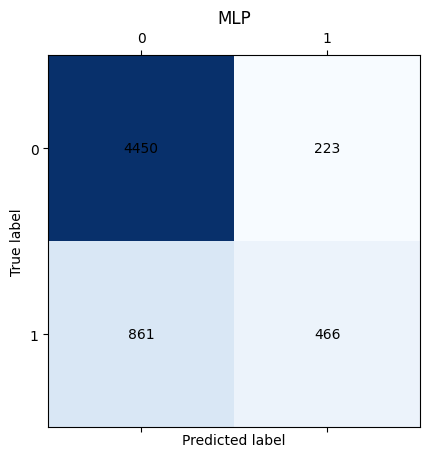

In [7]:
batch_size=10

dataset= UCL_Credit_Card_dataset(setname='val')
loader= DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
num_data = len(dataset)
num_batch = np.ceil(num_data / batch_size)

ylabel=np.zeros(len(loader)*batch_size)
ypredict=np.zeros(len(loader)*batch_size)
net.eval()

for batch, data in enumerate(loader, 1):
    with torch.no_grad():
        image = data['X'].to(device)
        label = data['y'].to(device).reshape(-1)
        output = net(image)
    ylabel[(batch-1)*batch_size:batch*batch_size]=label.to('cpu').numpy().reshape(batch_size)
    ypredict[(batch-1)*batch_size:batch*batch_size]=output.to('cpu').numpy().argmax(axis=1).reshape(batch_size)

print(ylabel)
print(ypredict)
C2= confusion_matrix(ylabel, ypredict)
print(C2)

def conf_matrix_drawing (conf_matrix,model_type):
    plt.matshow(conf_matrix, cmap=plt.cm.Blues)
    for i in range(len(conf_matrix)):
        for j in range(len(conf_matrix)):
           plt.annotate(conf_matrix[j, i], xy=(i, j),
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(model_type)
    plt.show()

conf_matrix_drawing(C2,'MLP')


In [8]:
accuracy = accuracy_score(ylabel, ypredict)
f1 = f1_score(ylabel, ypredict)
recall = recall_score(ylabel, ypredict)
print(accuracy,f1,recall)

0.8193333333333334 0.46230158730158727 0.35116804822908815
